# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

2023-05-16 12:16:05.602328: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

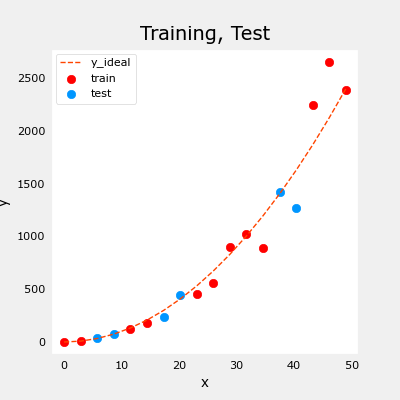

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ###
        err_i = ( (yhat[i] - y[i])**2 ) 
        err += err_i
       
    err = err / (2*m)
    
    ### END CODE HERE ### 
    
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [6]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

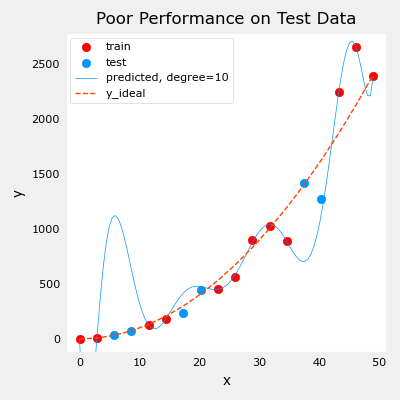

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [9]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

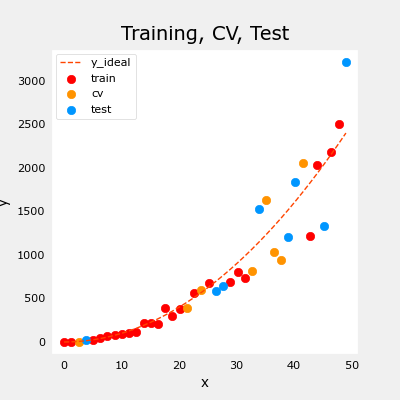

In [10]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [11]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

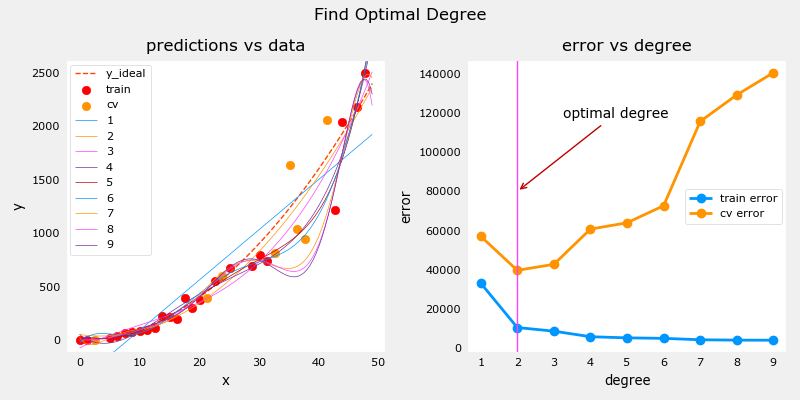

In [12]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [13]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

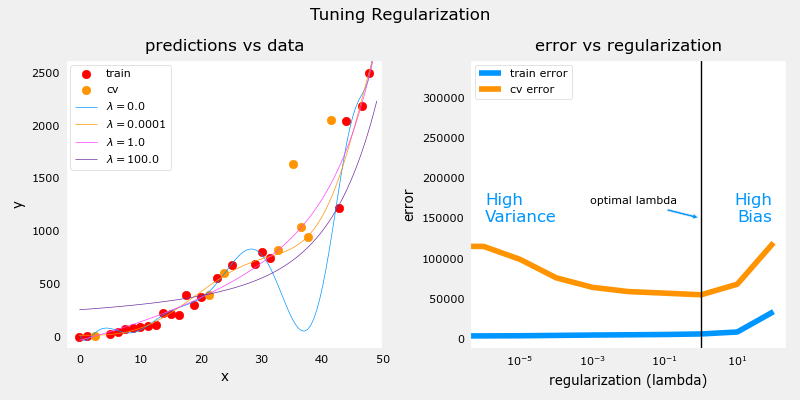

In [14]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

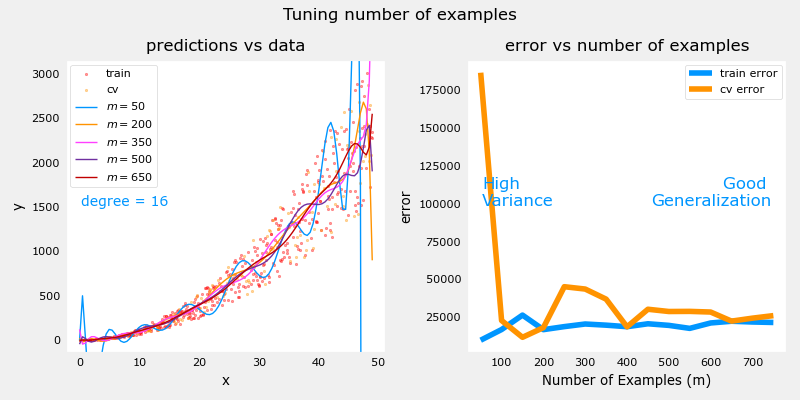

In [15]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [16]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


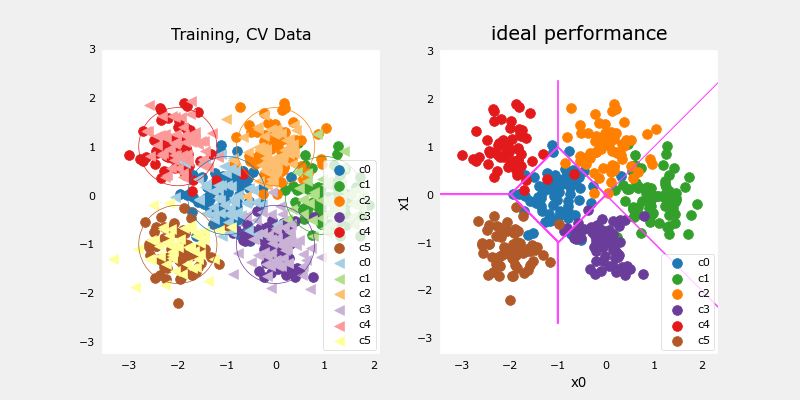

In [17]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [18]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr) 

In [19]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [20]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        Dense(120, activation = 'relu', name='L1'),
        Dense(40, activation = 'relu', name='L2'),
        Dense(6, activation = 'linear', name='L3')
        
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
    ### END CODE HERE ### 
)

In [21]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0278
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4132
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3308
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2915
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2590
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2711
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2405
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2272
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2261
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2038
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2162
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2088
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.1676
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1586
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1930
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1716
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1473
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1413
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1524
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1403
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1401
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1373
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1429
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1583
Epoch 113/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0749
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0669
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0613
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0788
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0635
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0660
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0532
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0573
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0703
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0725
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0589
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0273
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0277
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0267
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0284
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0313
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1176
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0258
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0263
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0257
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0233
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0209
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0247
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0269
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0184
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0211
Epoch 897/1000
13/1

In [22]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 1s 641us/step


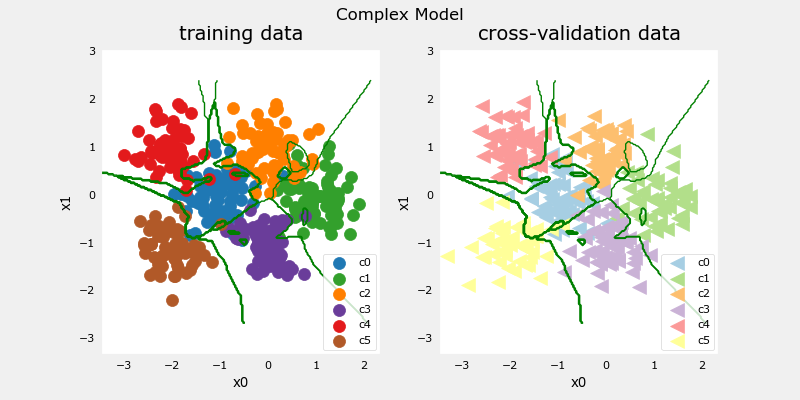

In [23]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [24]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 1ms/step
categorization error, training, complex model: 0.005
categorization error, cv,       complex model: 0.100


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [25]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        Dense(6, activation = 'relu', name='L1'),
        Dense(6, activation = 'linear', name='L2')     
        
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
    ### START CODE HERE ### 
)

In [26]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.8153
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.5788
Epoch 3/1000
13/13 [==============================] - 0s 957us/step - loss: 1.3620
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1263
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9093
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7417
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6283
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5416
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4828
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4388
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4077
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3875
Epoch 13/1000
13/13 [==

13/13 [==============================] - 0s 1ms/step - loss: 0.1925
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1945
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1903
Epoch 201/1000
13/13 [==============================] - 0s 980us/step - loss: 0.1901
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1889
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1896
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1904
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1889
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1920
Epoch 207/1000
13/13 [==============================] - 0s 933us/step - loss: 0.1884
Epoch 208/1000
13/13 [==============================] - 0s 990us/step - loss: 0.1928
Epoch 209/1000
13/13 [==============================] - 0s 959us/step - loss: 0.1887
Epoch 210/1

13/13 [==============================] - 0s 965us/step - loss: 0.1851
Epoch 394/1000
13/13 [==============================] - 0s 936us/step - loss: 0.1847
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1851
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1879
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1900
Epoch 398/1000
13/13 [==============================] - 0s 984us/step - loss: 0.1867
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1864
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1877
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1851
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1852
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1861
Epoch 405/100

13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 492/1000
13/13 [==============================] - 0s 940us/step - loss: 0.1845
Epoch 493/1000
13/13 [==============================] - 0s 939us/step - loss: 0.1873
Epoch 494/1000
13/13 [==============================] - 0s 910us/step - loss: 0.1852
Epoch 495/1000
13/13 [==============================] - 0s 980us/step - loss: 0.1842
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1891
Epoch 497/1000
13/13 [==============================] - 0s 974us/step - loss: 0.1842
Epoch 498/1000
13/13 [==============================] - 0s 986us/step - loss: 0.1849
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1852
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1845
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1896
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 5

13/13 [==============================] - 0s 1ms/step - loss: 0.1842
Epoch 688/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1846
Epoch 689/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1834
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1835
Epoch 691/1000
13/13 [==============================] - 0s 959us/step - loss: 0.1834
Epoch 692/1000
13/13 [==============================] - 0s 947us/step - loss: 0.1839
Epoch 693/1000
13/13 [==============================] - 0s 944us/step - loss: 0.1832
Epoch 694/1000
13/13 [==============================] - 0s 943us/step - loss: 0.1824
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1826
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1834
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1881
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1848
Epoch 699/1

Epoch 785/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1837
Epoch 786/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1885
Epoch 787/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1845
Epoch 788/1000
13/13 [==============================] - 0s 957us/step - loss: 0.1825
Epoch 789/1000
13/13 [==============================] - 0s 936us/step - loss: 0.1837
Epoch 790/1000
13/13 [==============================] - 0s 964us/step - loss: 0.1849
Epoch 791/1000
13/13 [==============================] - 0s 976us/step - loss: 0.1813
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1814
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1852
Epoch 794/1000
13/13 [==============================] - 0s 996us/step - loss: 0.1883
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1815
Epoch 796/1000
13/13 [==============================] - 0s 982us/step - loss:

13/13 [==============================] - 0s 1ms/step - loss: 0.1859
Epoch 884/1000
13/13 [==============================] - 0s 965us/step - loss: 0.1806
Epoch 885/1000
13/13 [==============================] - 0s 949us/step - loss: 0.1824
Epoch 886/1000
13/13 [==============================] - 0s 972us/step - loss: 0.1812
Epoch 887/1000
13/13 [==============================] - 0s 1000us/step - loss: 0.1840
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1829
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1825
Epoch 890/1000
13/13 [==============================] - 0s 986us/step - loss: 0.1867
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1826
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1844
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1830
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1844
Epoch 89

In [27]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 6)                 18        
                                                                 
 L2 (Dense)                  (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 601us/step


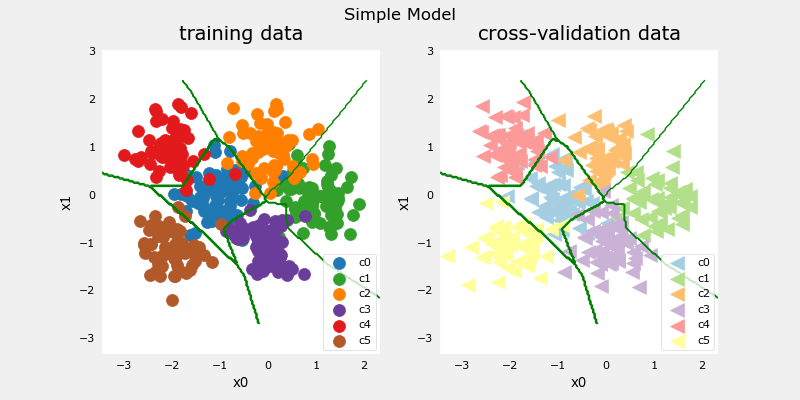

In [28]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [29]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 1ms/step
categorization error, training, simple model, 0.072, complex model: 0.005
categorization error, cv,       simple model, 0.066, complex model: 0.100


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [30]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name='L1'),
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name='L2'),
        Dense(6, activation = 'linear', name='L3') 
        
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
    ### START CODE HERE ### 
)

In [31]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 4.4336
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.6846
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.3113
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0692
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9859
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9536
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9328
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8879
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8087
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7703
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7575
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7552
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.4895
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4746
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4731
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4658
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5128
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4629
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4643
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4749
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4638
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4559
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4602
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4527
Epoch 113/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3929
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3964
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3931
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4293
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3927
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3952
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3948
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3778
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3773
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3892
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3936
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3891
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3541
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3551
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3534
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3745
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4041
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3522
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3445
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3622
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3554
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3624
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3839
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3665
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4055
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3742
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3494
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3545
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3519
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3476
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3396
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3364
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3347
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3474
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3432
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3494
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3570
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3418
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3263
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3452
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3387
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3735
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3588
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3461
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3499
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3580
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3915
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3600
Epoch 897/1000
13/1

In [32]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 120)               360       
                                                                 
 L2 (Dense)                  (None, 40)                4840      
                                                                 
 L3 (Dense)                  (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 646us/step


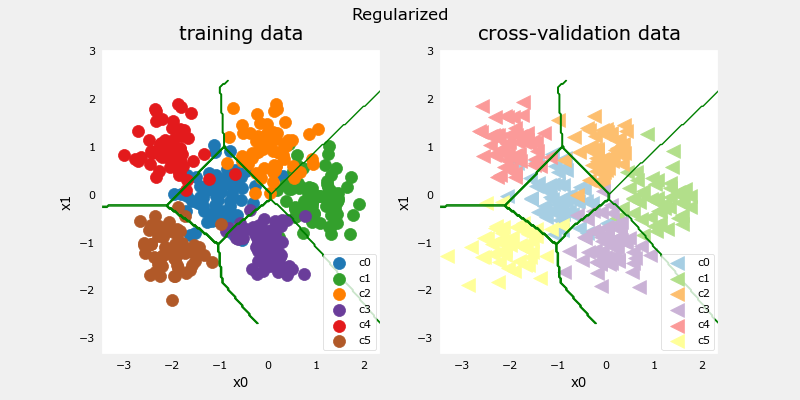

In [33]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [34]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 2ms/step
categorization error, training, regularized: 0.083, simple model, 0.072, complex model: 0.005
categorization error, cv,       regularized: 0.081, simple model, 0.066, complex model: 0.100


The simple model is a bit better in the training set than the regularized model but worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [35]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)

for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0487
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4232
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3206
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2811
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2748
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2965
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2562
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2290
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2310
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2096
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2163
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2065
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 1ms/step - loss: 0.1796
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1645
Epoch 103/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1659
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1540
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1513
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1603
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1477
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1473
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1443
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1483
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1571
Epoch 113/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1087
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0747
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0683
Epoch 300/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0859
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0770
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0880
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0817
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0657
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0762
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0794
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0814
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0783
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0902
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0801
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0664
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1068
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0890
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0643
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0514
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0562
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0418
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0507
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0393
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0244
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0246
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0772
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1345
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0832
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0898
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0901
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0697
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0239
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0231
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0208
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 897/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2439
Epoch 83/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2338
Epoch 84/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2354
Epoch 85/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2563
Epoch 86/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2330
Epoch 87/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2298
Epoch 88/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2320
Epoch 89/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2292
Epoch 90/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2244
Epoch 91/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2192
Epoch 92/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2183
Epoch 93/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2216
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.2243
Epoch 182/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2117
Epoch 183/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2057
Epoch 184/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2085
Epoch 185/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2084
Epoch 186/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2036
Epoch 187/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2041
Epoch 188/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2044
Epoch 189/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1999
Epoch 190/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2065
Epoch 191/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2138
Epoch 192/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2084
Epoch 193/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1777
Epoch 378/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1855
Epoch 379/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1871
Epoch 380/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1858
Epoch 381/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1865
Epoch 382/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1894
Epoch 383/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1935
Epoch 384/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1848
Epoch 385/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1832
Epoch 386/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1813
Epoch 387/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1855
Epoch 388/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1878
Epoch 389/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1733
Epoch 574/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1707
Epoch 575/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1659
Epoch 576/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1635
Epoch 577/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1701
Epoch 578/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1818
Epoch 579/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1631
Epoch 580/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1691
Epoch 581/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1705
Epoch 582/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1605
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1663
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1707
Epoch 585/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1544
Epoch 770/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1586
Epoch 771/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1609
Epoch 772/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1588
Epoch 773/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1585
Epoch 774/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1661
Epoch 775/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1654
Epoch 776/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1543
Epoch 777/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1527
Epoch 778/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1604
Epoch 779/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1547
Epoch 780/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1558
Epoch 781/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1586
Epoch 966/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1565
Epoch 967/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 968/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1694
Epoch 969/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1538
Epoch 970/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1560
Epoch 971/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1546
Epoch 972/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1447
Epoch 973/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1449
Epoch 974/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1544
Epoch 975/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1522
Epoch 976/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1520
Epoch 977/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2810
Epoch 164/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2904
Epoch 165/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2911
Epoch 166/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2828
Epoch 167/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2812
Epoch 168/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2822
Epoch 169/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2838
Epoch 170/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2837
Epoch 171/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2701
Epoch 172/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2608
Epoch 173/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2854
Epoch 174/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2886
Epoch 175/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2510
Epoch 360/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2772
Epoch 361/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2486
Epoch 362/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2824
Epoch 363/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2760
Epoch 364/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2614
Epoch 365/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2583
Epoch 366/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2608
Epoch 367/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2764
Epoch 368/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2604
Epoch 369/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2518
Epoch 370/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2541
Epoch 371/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2441
Epoch 556/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2304
Epoch 557/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2373
Epoch 558/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2429
Epoch 559/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2563
Epoch 560/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2510
Epoch 561/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2422
Epoch 562/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2548
Epoch 563/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2330
Epoch 564/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2445
Epoch 565/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2370
Epoch 566/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2432
Epoch 567/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2292
Epoch 752/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2356
Epoch 753/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2210
Epoch 754/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2356
Epoch 755/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2291
Epoch 756/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2436
Epoch 757/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2418
Epoch 758/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2299
Epoch 759/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2260
Epoch 760/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2381
Epoch 761/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2357
Epoch 762/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2327
Epoch 763/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2311
Epoch 948/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2288
Epoch 949/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2191
Epoch 950/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2177
Epoch 951/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2246
Epoch 952/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2375
Epoch 953/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2333
Epoch 954/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2384
Epoch 955/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2239
Epoch 956/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2280
Epoch 957/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2270
Epoch 958/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2332
Epoch 959/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3517
Epoch 146/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 147/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3661
Epoch 148/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3530
Epoch 149/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3485
Epoch 150/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3501
Epoch 151/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3494
Epoch 152/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3437
Epoch 153/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3666
Epoch 154/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3466
Epoch 155/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3481
Epoch 156/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3564
Epoch 157/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3230
Epoch 342/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3309
Epoch 343/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3172
Epoch 344/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3144
Epoch 345/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3132
Epoch 346/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3242
Epoch 347/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3283
Epoch 348/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3329
Epoch 349/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3044
Epoch 350/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3261
Epoch 351/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3100
Epoch 352/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3335
Epoch 353/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3616
Epoch 538/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3182
Epoch 539/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2932
Epoch 540/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3148
Epoch 541/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3233
Epoch 542/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3295
Epoch 543/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3243
Epoch 544/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3108
Epoch 545/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3028
Epoch 546/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3116
Epoch 547/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3272
Epoch 548/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3114
Epoch 549/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2945
Epoch 734/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3107
Epoch 735/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3134
Epoch 736/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3183
Epoch 737/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3087
Epoch 738/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3371
Epoch 739/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3194
Epoch 740/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3194
Epoch 741/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3316
Epoch 742/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3526
Epoch 743/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2945
Epoch 744/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2919
Epoch 745/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2998
Epoch 930/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3199
Epoch 931/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3323
Epoch 932/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3054
Epoch 933/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3013
Epoch 934/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3198
Epoch 935/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2910
Epoch 936/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2847
Epoch 937/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2922
Epoch 938/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3115
Epoch 939/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2893
Epoch 940/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2840
Epoch 941/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.6212
Epoch 29/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6081
Epoch 30/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6277
Epoch 31/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6221
Epoch 32/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6437
Epoch 33/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6251
Epoch 34/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6717
Epoch 35/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6646
Epoch 36/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6406
Epoch 37/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6011
Epoch 38/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5769
Epoch 39/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5763
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.4352
Epoch 226/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4344
Epoch 227/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4624
Epoch 228/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4046
Epoch 229/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4049
Epoch 230/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4157
Epoch 231/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4034
Epoch 232/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4227
Epoch 233/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3979
Epoch 234/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3936
Epoch 235/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3916
Epoch 236/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3981
Epoch 237/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3713
Epoch 422/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3843
Epoch 423/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3685
Epoch 424/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3718
Epoch 425/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3579
Epoch 426/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3547
Epoch 427/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3624
Epoch 428/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3729
Epoch 429/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3712
Epoch 430/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3735
Epoch 431/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3562
Epoch 432/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3641
Epoch 433/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3324
Epoch 618/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3771
Epoch 619/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3987
Epoch 620/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3857
Epoch 621/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3440
Epoch 622/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3441
Epoch 623/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3384
Epoch 624/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3272
Epoch 625/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3239
Epoch 626/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3380
Epoch 627/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3487
Epoch 628/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3610
Epoch 629/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3356
Epoch 814/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3350
Epoch 815/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3332
Epoch 816/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3328
Epoch 817/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3493
Epoch 818/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 819/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3218
Epoch 820/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3558
Epoch 821/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3831
Epoch 822/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3432
Epoch 823/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3371
Epoch 824/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3490
Epoch 825/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 1.0334
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0027
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9684
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9461
Epoch 13/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9446
Epoch 14/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9485
Epoch 15/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9053
Epoch 16/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8958
Epoch 17/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9145
Epoch 18/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9101
Epoch 19/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8728
Epoch 20/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8546
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5681
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5692
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5634
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5568
Epoch 113/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5483
Epoch 114/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5496
Epoch 115/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5525
Epoch 116/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5519
Epoch 117/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5870
Epoch 118/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5847
Epoch 119/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5759
Epoch 120/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5665
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.4488
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4760
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4570
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4437
Epoch 309/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4541
Epoch 310/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4461
Epoch 311/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4392
Epoch 312/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4397
Epoch 313/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4460
Epoch 314/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4491
Epoch 315/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4433
Epoch 316/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4381
Epoch 317/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4031
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4127
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4382
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4546
Epoch 505/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 506/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4533
Epoch 507/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4445
Epoch 508/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4010
Epoch 509/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4090
Epoch 510/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4060
Epoch 511/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4181
Epoch 512/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4133
Epoch 513/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3854
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3994
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3837
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3737
Epoch 701/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3977
Epoch 702/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3980
Epoch 703/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3897
Epoch 704/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4103
Epoch 705/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3932
Epoch 706/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4015
Epoch 707/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4065
Epoch 708/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3972
Epoch 709/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3921
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3792
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4233
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3907
Epoch 897/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3847
Epoch 898/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3798
Epoch 899/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4107
Epoch 900/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3908
Epoch 901/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4209
Epoch 902/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4105
Epoch 903/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4069
Epoch 904/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3662
Epoch 905/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.6903
Epoch 91/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7004
Epoch 92/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6798
Epoch 93/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6822
Epoch 94/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6680
Epoch 95/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6772
Epoch 96/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6606
Epoch 97/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6579
Epoch 98/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6709
Epoch 99/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6905
Epoch 100/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6958
Epoch 101/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6835
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5895
Epoch 190/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5744
Epoch 191/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5934
Epoch 192/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5829
Epoch 193/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5827
Epoch 194/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5662
Epoch 195/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5613
Epoch 196/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5560
Epoch 197/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5659
Epoch 198/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5593
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5655
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5757
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.4967
Epoch 386/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4809
Epoch 387/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4989
Epoch 388/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5065
Epoch 389/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4950
Epoch 390/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4823
Epoch 391/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4859
Epoch 392/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4887
Epoch 393/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4851
Epoch 394/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4866
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5104
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5318
Epoch 397/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4785
Epoch 582/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4716
Epoch 583/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4706
Epoch 584/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4495
Epoch 585/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4690
Epoch 586/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4912
Epoch 587/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4607
Epoch 588/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4574
Epoch 589/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4331
Epoch 590/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4345
Epoch 591/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4455
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4426
Epoch 593/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4695
Epoch 778/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4923
Epoch 779/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4455
Epoch 780/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4352
Epoch 781/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4587
Epoch 782/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4201
Epoch 783/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4322
Epoch 784/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4318
Epoch 785/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4152
Epoch 786/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4213
Epoch 787/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4309
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4191
Epoch 789/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4082
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4104
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4001
Epoch 976/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4060
Epoch 977/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4093
Epoch 978/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4036
Epoch 979/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4198
Epoch 980/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4422
Epoch 981/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4324
Epoch 982/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4360
Epoch 983/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4091
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4227
Epoch 985/1000
13/1

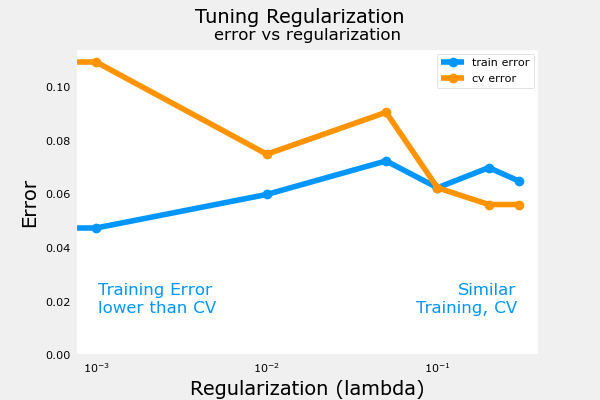

In [36]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 2ms/step


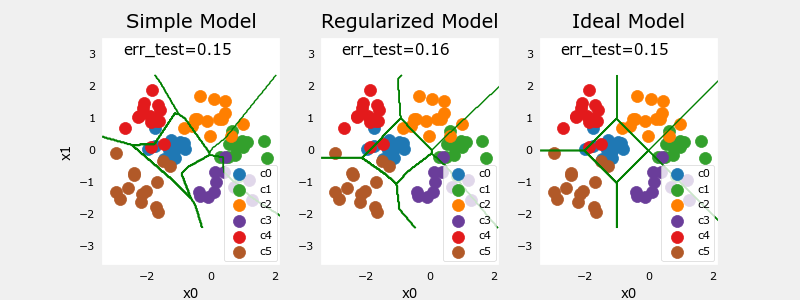

In [37]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>